In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap
from explainerdashboard import ExplainerDashboard, ClassifierExplainer
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import captum.attr as c
import time
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import os
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import NearMiss

In [2]:
data = pd.read_csv('Cleaned_full_data.csv')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_9632\2584280520.py:1: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

In [4]:
# Avoids scaling binaries.
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [5]:
# Add encoded values for correlation encoder. The encoded values are based on all threats vs Normal labels.
ohe1 = pd.read_csv('Full_proto_encoded.csv')
ohe2 = pd.read_csv('Full_dsport_encoded.csv')
ohe3 = pd.read_csv('Full_service_encoded.csv')
ohe4 = pd.read_csv('Full_state_encoded.csv')
# Spelling error.
ohe5 = pd.read_csv('Full_scrip_encoded.csv')
#------------------------------------------#
ohe6 = pd.read_csv('Full_sport_encoded.csv')
ohe7 = pd.read_csv('Full_dstip_encoded.csv')

In [6]:
# MinMax seperates Normal data well and reduces noise. Please see Kmeans TSNE evaluation in Tools.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)
# Combine data after scaling.
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, data['label'], test_size=0.2, random_state=42)
# Drop attack cat before running model and store for later evaluation indexing.
test_attack_cat = X_test['attack_cat']
print(X_test['label'].value_counts())
# Drop labels from X sets pre training.
X_train = X_train.drop(columns=['attack_cat', 'label'])
X_test = X_test.drop(columns=['attack_cat', 'label'])

label
0    443831
1     64179
Name: count, dtype: int64


In [8]:
# Prepare batches.
batch_size = 512
# Convert to tensors. BCE requires float type.
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Add to Dataloader to manage batch processing.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
print(len(train_loader))

3969


In [10]:
n_dynamic = 100
random_indices = np.random.randint(0, len(train_loader), size=n_dynamic)

train_list = []
label_list = []
i = 0

for batch_idx, (train_seq, train_label) in enumerate(train_loader):
    batch_size = len(train_seq)
    smote_neighbors = min(batch_size, 2)
    if i in random_indices:
        train_smote, train_label_smote = train_seq, train_label
    else:

        if batch_size > 1:
            try:
                smote = SMOTE(random_state=42, k_neighbors=smote_neighbors)
                smote_resampled, smote_resampled_labels = smote.fit_resample(train_seq.numpy(), train_label.numpy())
                smote_resampled = torch.tensor(smote_resampled, dtype=torch.float32)
                smote_resampled_labels = torch.tensor(smote_resampled_labels, dtype=torch.float32)
                train_smote = smote_resampled
                train_label_smote = smote_resampled_labels

            except ValueError as e:
                print(f"Error running SMOTE: {e}")
                train_smote, train_label_smote = train_seq, train_label
        else:
            train_smote, train_label_smote = train_seq, train_label
    train_list.append(train_smote)
    label_list.append(train_label_smote)
    i += 1

In [11]:
print(len(train_list))

3969


In [12]:
# Concatenate with torch - pd seems to cause memory allocation errors.
train_full = torch.cat(train_list, dim=0)
train_label_full = torch.cat(label_list, dim=0)
# Convert back to pd for Random Forest.
train_full = train_full.numpy()
X_train_columns = X_train.columns.tolist()
data_train = pd.DataFrame(train_full, columns=X_train_columns)
data_label = pd.Series(train_label_full)

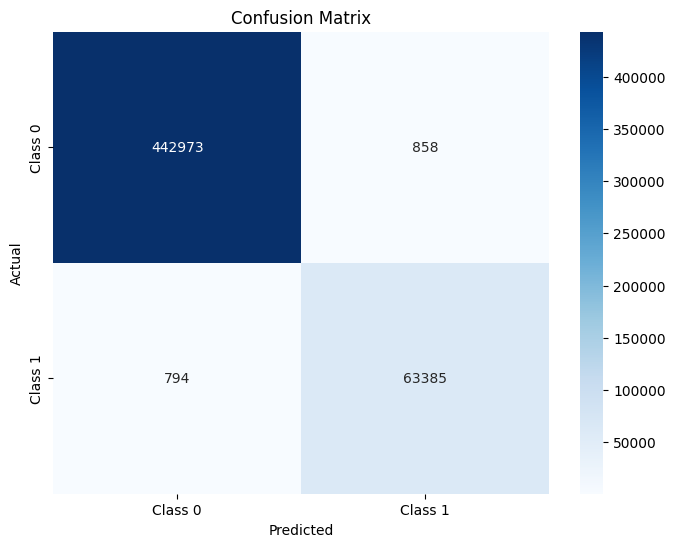

Accuracy: 0.9967
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010



In [13]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(data_train, data_label)
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [14]:
# We can't seem to reproduce the same result as torch has epochs.
n_dynamic = 1000
random_indices = np.random.randint(0, len(train_loader), size=n_dynamic)

train_list = []
label_list = []
i = 0

for batch_idx, (train_seq, train_label) in enumerate(train_loader):
    batch_size = len(train_seq)
    smote_neighbors = min(batch_size, 2)
    if i in random_indices:
        train_smote, train_label_smote = train_seq, train_label
    else:

        if batch_size > 1:
            try:
                smote = SMOTE(random_state=42, k_neighbors=smote_neighbors)
                smote_resampled, smote_resampled_labels = smote.fit_resample(train_seq.numpy(), train_label.numpy())
                smote_resampled = torch.tensor(smote_resampled, dtype=torch.float32)
                smote_resampled_labels = torch.tensor(smote_resampled_labels, dtype=torch.float32)
                train_smote = smote_resampled
                train_label_smote = smote_resampled_labels

            except ValueError as e:
                print(f"Error running SMOTE: {e}")
                train_smote, train_label_smote = train_seq, train_label
        else:
            train_smote, train_label_smote = train_seq, train_label
    train_list.append(train_smote)
    label_list.append(train_label_smote)
    i += 1

In [15]:
print(len(train_list))

3969


In [16]:
# Concatenate with torch - pd seems to cause memory allocation errors.
train_full = torch.cat(train_list, dim=0)
train_label_full = torch.cat(label_list, dim=0)
# Convert back to pd for Random Forest.
train_full = train_full.numpy()
X_train_columns = X_train.columns.tolist()
data_train = pd.DataFrame(train_full, columns=X_train_columns)
data_label = pd.Series(train_label_full)

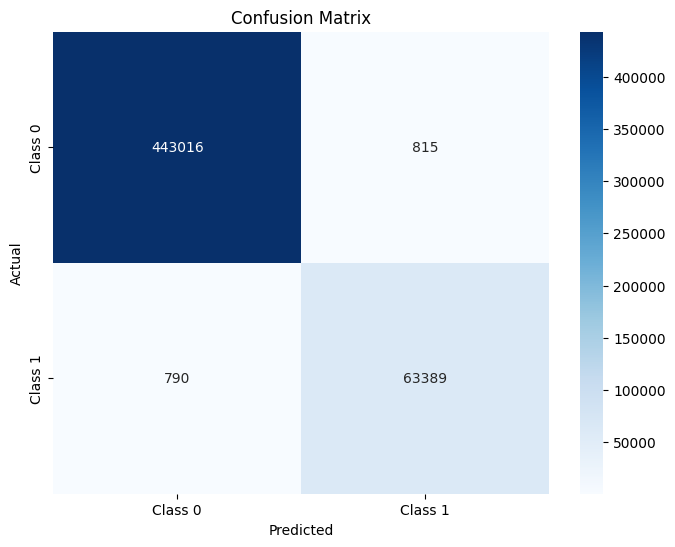

Accuracy: 0.9968
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010



In [17]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(data_train, data_label)
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [18]:
# Prepare batches.
batch_size = 128
# Convert to tensors. BCE requires float type.
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Add to Dataloader to manage batch processing.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
n_dynamic = 1000
random_indices = np.random.randint(0, len(train_loader), size=n_dynamic)

train_list = []
label_list = []
i = 0

for batch_idx, (train_seq, train_label) in enumerate(train_loader):
    batch_size = len(train_seq)
    smote_neighbors = min(batch_size, 2)
    if i in random_indices:
        train_smote, train_label_smote = train_seq, train_label
    else:

        if batch_size > 1:
            try:
                smote = SMOTE(random_state=42, k_neighbors=smote_neighbors)
                smote_resampled, smote_resampled_labels = smote.fit_resample(train_seq.numpy(), train_label.numpy())
                smote_resampled = torch.tensor(smote_resampled, dtype=torch.float32)
                smote_resampled_labels = torch.tensor(smote_resampled_labels, dtype=torch.float32)
                train_smote = smote_resampled
                train_label_smote = smote_resampled_labels

            except ValueError as e:
                print(f"Error running SMOTE: {e}")
                train_smote, train_label_smote = train_seq, train_label
        else:
            train_smote, train_label_smote = train_seq, train_label
    train_list.append(train_smote)
    label_list.append(train_label_smote)
    i += 1

In [20]:
print(len(train_list))

15876


In [21]:
# Concatenate with torch - pd seems to cause memory allocation errors.
train_full = torch.cat(train_list, dim=0)
train_label_full = torch.cat(label_list, dim=0)
# Convert back to pd for Random Forest.
train_full = train_full.numpy()
X_train_columns = X_train.columns.tolist()
data_train = pd.DataFrame(train_full, columns=X_train_columns)
data_label = pd.Series(train_label_full)

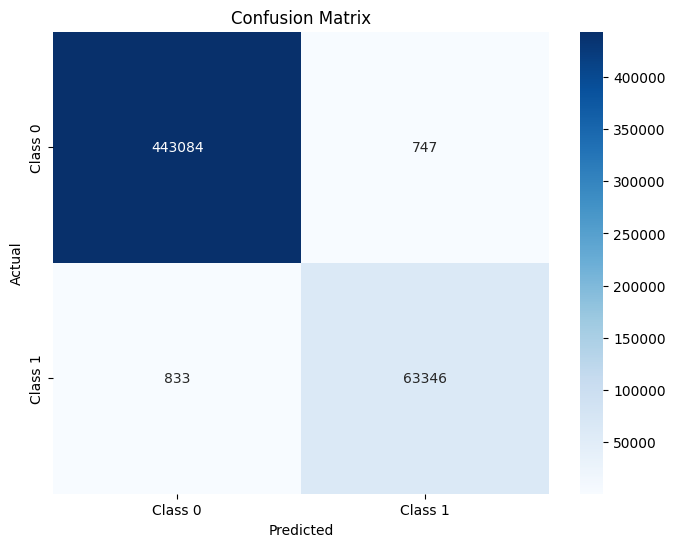

Accuracy: 0.9969
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010



In [22]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(data_train, data_label)
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [23]:
# Prepare batches.
batch_size = 1024
# Convert to tensors. BCE requires float type.
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Add to Dataloader to manage batch processing.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# Run without Dynamic and increase Neighbours
n_dynamic = 0
random_indices = np.random.randint(0, len(train_loader), size=n_dynamic)

train_list = []
label_list = []
i = 0

for batch_idx, (train_seq, train_label) in enumerate(train_loader):
    batch_size = len(train_seq)
    smote_neighbors = min(batch_size, 3)
    if i in random_indices:
        train_smote, train_label_smote = train_seq, train_label
    else:

        if batch_size > 1:
            try:
                smote = SMOTE(random_state=42, k_neighbors=smote_neighbors)
                smote_resampled, smote_resampled_labels = smote.fit_resample(train_seq.numpy(), train_label.numpy())
                smote_resampled = torch.tensor(smote_resampled, dtype=torch.float32)
                smote_resampled_labels = torch.tensor(smote_resampled_labels, dtype=torch.float32)
                train_smote = smote_resampled
                train_label_smote = smote_resampled_labels

            except ValueError as e:
                print(f"Error running SMOTE: {e}")
                train_smote, train_label_smote = train_seq, train_label
        else:
            train_smote, train_label_smote = train_seq, train_label
    train_list.append(train_smote)
    label_list.append(train_label_smote)
    i += 1

In [25]:
print(len(train_list))

1985


In [26]:
# Concatenate with torch - pd seems to cause memory allocation errors.
train_full = torch.cat(train_list, dim=0)
train_label_full = torch.cat(label_list, dim=0)
# Convert back to pd for Random Forest.
train_full = train_full.numpy()
X_train_columns = X_train.columns.tolist()
data_train = pd.DataFrame(train_full, columns=X_train_columns)
data_label = pd.Series(train_label_full)

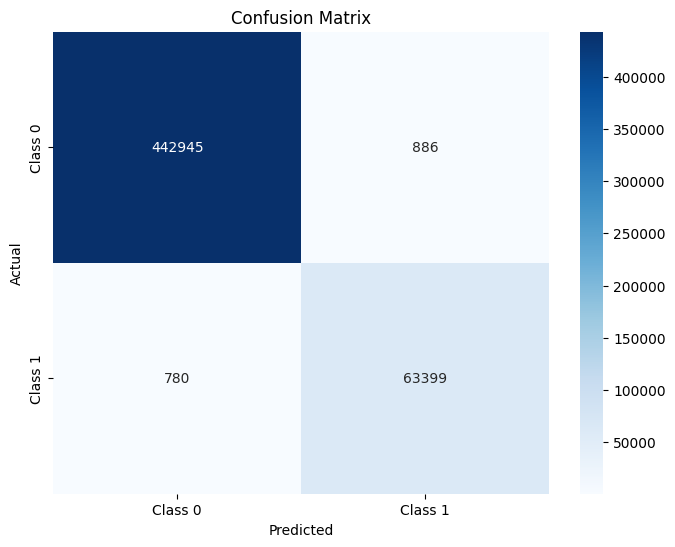

Accuracy: 0.9967
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010



In [27]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(data_train, data_label)
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [28]:
# Prepare batches.
batch_size = 1024
# Convert to tensors. BCE requires float type.
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Add to Dataloader to manage batch processing.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
# Run without Dynamic and increase Neighbours even more.
n_dynamic = 0
random_indices = np.random.randint(0, len(train_loader), size=n_dynamic)

train_list = []
label_list = []
i = 0

for batch_idx, (train_seq, train_label) in enumerate(train_loader):
    batch_size = len(train_seq)
    smote_neighbors = min(batch_size, 10)
    if i in random_indices:
        train_smote, train_label_smote = train_seq, train_label
    else:

        if batch_size > 1:
            try:
                smote = SMOTE(random_state=42, k_neighbors=smote_neighbors)
                smote_resampled, smote_resampled_labels = smote.fit_resample(train_seq.numpy(), train_label.numpy())
                smote_resampled = torch.tensor(smote_resampled, dtype=torch.float32)
                smote_resampled_labels = torch.tensor(smote_resampled_labels, dtype=torch.float32)
                train_smote = smote_resampled
                train_label_smote = smote_resampled_labels

            except ValueError as e:
                print(f"Error running SMOTE: {e}")
                train_smote, train_label_smote = train_seq, train_label
        else:
            train_smote, train_label_smote = train_seq, train_label
    train_list.append(train_smote)
    label_list.append(train_label_smote)
    i += 1

In [30]:
print(len(train_list))

1985


In [31]:
# Concatenate with torch - pd seems to cause memory allocation errors.
train_full = torch.cat(train_list, dim=0)
train_label_full = torch.cat(label_list, dim=0)
# Convert back to pd for Random Forest.
train_full = train_full.numpy()
X_train_columns = X_train.columns.tolist()
data_train = pd.DataFrame(train_full, columns=X_train_columns)
data_label = pd.Series(train_label_full)

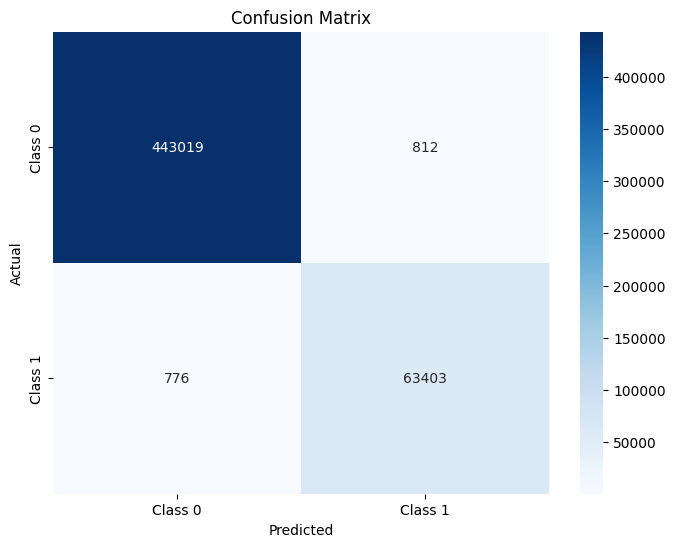

Accuracy: 0.9969
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010



In [32]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(data_train, data_label)
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [33]:
# Run without Dynamic and increase Neighbours even more.
n_dynamic = 0
random_indices = np.random.randint(0, len(train_loader), size=n_dynamic)

train_list = []
label_list = []
i = 0

for batch_idx, (train_seq, train_label) in enumerate(train_loader):
    batch_size = len(train_seq)
    smote_neighbors = min(batch_size, 30)
    if i in random_indices:
        train_smote, train_label_smote = train_seq, train_label
    else:

        if batch_size > 1:
            try:
                smote = SMOTE(random_state=42, k_neighbors=smote_neighbors)
                smote_resampled, smote_resampled_labels = smote.fit_resample(train_seq.numpy(), train_label.numpy())
                smote_resampled = torch.tensor(smote_resampled, dtype=torch.float32)
                smote_resampled_labels = torch.tensor(smote_resampled_labels, dtype=torch.float32)
                train_smote = smote_resampled
                train_label_smote = smote_resampled_labels

            except ValueError as e:
                print(f"Error running SMOTE: {e}")
                train_smote, train_label_smote = train_seq, train_label
        else:
            print('Error in Smote 2.')
            train_smote, train_label_smote = train_seq, train_label
    train_list.append(train_smote)
    label_list.append(train_label_smote)
    i += 1

In [34]:
print(len(train_list))

1985


In [35]:
# Concatenate with torch - pd seems to cause memory allocation errors.
train_full = torch.cat(train_list, dim=0)
train_label_full = torch.cat(label_list, dim=0)
# Convert back to pd for Random Forest.
train_full = train_full.numpy()
X_train_columns = X_train.columns.tolist()
data_train = pd.DataFrame(train_full, columns=X_train_columns)
data_label = pd.Series(train_label_full)

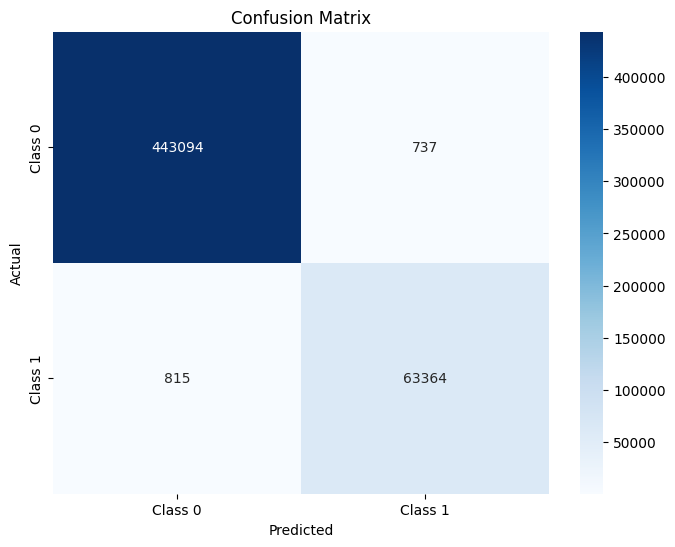

Accuracy: 0.9969
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010



In [36]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(data_train, data_label)
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

In [37]:
# Run without Dynamic and increase Neighbours even more.
n_dynamic = 0
random_indices = np.random.randint(0, len(train_loader), size=n_dynamic)

train_list = []
label_list = []
i = 0

for batch_idx, (train_seq, train_label) in enumerate(train_loader):
    batch_size = len(train_seq)
    smote_neighbors = min(batch_size, 100)
    if i in random_indices:
        train_smote, train_label_smote = train_seq, train_label
    else:

        if batch_size > 1:
            try:
                smote = SMOTE(random_state=42, k_neighbors=smote_neighbors)
                smote_resampled, smote_resampled_labels = smote.fit_resample(train_seq.numpy(), train_label.numpy())
                smote_resampled = torch.tensor(smote_resampled, dtype=torch.float32)
                smote_resampled_labels = torch.tensor(smote_resampled_labels, dtype=torch.float32)
                train_smote = smote_resampled
                train_label_smote = smote_resampled_labels

            except ValueError as e:
                print(f"Error running SMOTE: {e}")
                train_smote, train_label_smote = train_seq, train_label
        else:
            print('Error in Smote 2.')
            train_smote, train_label_smote = train_seq, train_label
    train_list.append(train_smote)
    label_list.append(train_label_smote)
    i += 1

Error running SMOTE: Expected n_neighbors <= n_samples_fit, but n_neighbors = 101, n_samples_fit = 96, n_samples = 96
Error running SMOTE: Expected n_neighbors <= n_samples_fit, but n_neighbors = 101, n_samples_fit = 100, n_samples = 100
Error running SMOTE: Expected n_neighbors <= n_samples_fit, but n_neighbors = 101, n_samples_fit = 99, n_samples = 99
Error running SMOTE: Expected n_neighbors <= n_samples_fit, but n_neighbors = 101, n_samples_fit = 100, n_samples = 100
Error running SMOTE: Expected n_neighbors <= n_samples_fit, but n_neighbors = 101, n_samples_fit = 93, n_samples = 93
Error running SMOTE: Expected n_neighbors <= n_samples_fit, but n_neighbors = 101, n_samples_fit = 48, n_samples = 48


In [38]:
# Concatenate with torch - pd seems to cause memory allocation errors.
train_full = torch.cat(train_list, dim=0)
train_label_full = torch.cat(label_list, dim=0)
# Convert back to pd for Random Forest.
train_full = train_full.numpy()
X_train_columns = X_train.columns.tolist()
data_train = pd.DataFrame(train_full, columns=X_train_columns)
data_label = pd.Series(train_label_full)
print(len(data_train))

3545397


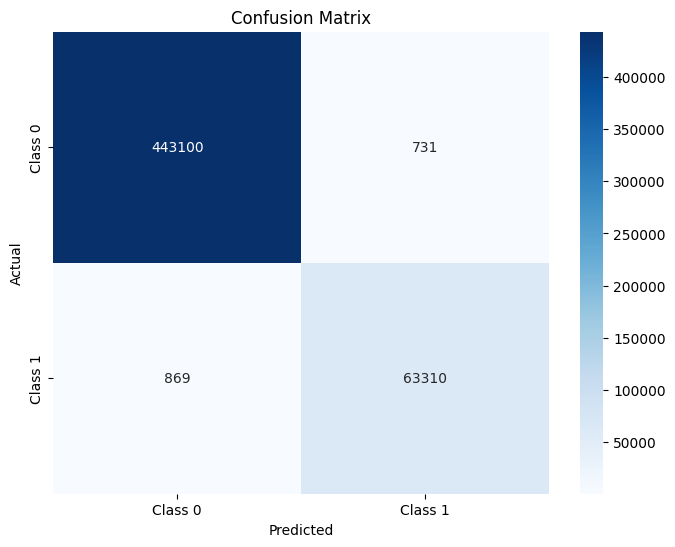

Accuracy: 0.9969
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010



In [39]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(data_train, data_label)
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))